<a href="https://colab.research.google.com/github/meishihna/GITHUB-COLAB/blob/main/%E6%90%9E%E6%90%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**工具**

In [ ]:
!pip install FinMind
!pip install --upgrade mplfinance

In [53]:
import pandas as pd
# from Data import getDataYF,getDataFM
import mplfinance as mpf
import matplotlib.pyplot as plt

In [54]:
import yfinance as yf
import FinMind
from FinMind.data import DataLoader

def getDataYF(prod,st,en):
  data=yf.download(prod,start=st,end=en)
  data.columns=[i.lower() for i in data.columns]
  return data

def getDataFM(prod,st,en):
  FM = DataLoader()
  df = FM.taiwan_stock_daily(stock_id=prod, start_date = st, end_date =en)
## 整理資料格式
  df = df.rename(columns={"date": "Date"})
  df.set_index("Date" , inplace=True)
  df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df.index)))
## backtesting.py 格式
  df1 = df.rename(columns={"open": "Open", "max": "High", "min": "Low", "close": "Close", "Trading_Volume": "Volume"})
## ta-lib 格式
  df2 = df.rename(columns={"max": "high", "min": "low", "Trading_Volume": "Volume"})
  return df1

def ChartCandle(data,addp=[]):
  mcolor = mpf.make_marketcolors(up='r',down='g',inherit = True)
  mstyle = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors = mcolor)
  mpf.plot(data,addplot = addp,style = mstyle,type = 'candle',volume= True)

def ChartTrade(data,trade=pd.DataFrame(),addp=[],v_enable=True):

  addp = addp.copy()
  data1 = data.copy()

  if trade.shape[0] > 0:
    trade1 = trade.copy()
    # 進場明細
    buy_order_trade = trade1[[2,3]]
    buy_order_trade = buy_order_trade.set_index(2)
    buy_order_trade.columns = ['buy_order']
    buy_order_trade = buy_order_trade.drop_duplicates()
    # 出場明細
    buy_cover_trade = trade1[[4,5]]
    buy_cover_trade = buy_cover_trade.set_index(4)
    buy_cover_trade.columns = ['buy_cover']
    buy_cover_trade = buy_cover_trade.drop_duplicates()

    data1 = pd.concat([data1,buy_order_trade,buy_cover_trade], axis = 1)

    addp.append(mpf.make_addplot(data1['buy_order']
            ,type = 'scatter', color = '#FF4500'
            ,marker = '^',markersize = 50))
    addp.append(mpf.make_addplot(data1['buy_cover']
            ,type = 'scatter',color = '#16982B'
            ,marker = 'v',markersize = 50))
  mcolor = mpf.make_marketcolors(up = 'r',down = 'g',inherit = True)
  mstyle = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors = mcolor)
  mpf.plot(data1,addplot = addp,style = mstyle,type = 'candle',volume = v_enable)

def Performance(trade=pd.DataFrame(),prodtype='ETF'):
  if trade.shape[0] == 0:
    print("沒有交易紀錄")
    return False

  if prodtype == 'ETF':
    cost = 0.001 + 0.00285
  elif prodtype == 'Stock':
    cost = 0.003 + 0.00285
  else:
    return False

  trade1 = trade.copy()
  trade1 = trade1.sort_values(2)
  trade1 = trade1.reset_index(drop = True)

  trade1.columns = ['product','bs','order_time','order_price','cover_time','cover_price' ,'order_unit']

  trade1['ret'] = (((trade1['cover_price']-trade1['order_price'])/trade1['order_price'])-cost)*trade1['order_unit']
  print("總績效%s"%(trade1['ret'].sum().round(4)))

  print('交易次數%s'%(trade1.shape[0]))

  print('平均績效%s'%(trade1['ret'].mean().round(4)))

  onopen_day = (trade1['cover_time']-trade1['order_time']).mean()
  print('平均持有天數%s天'%(onopen_day.days))

  earn_trade=trade1[trade1['ret']>0]
  loss_trade=trade1[trade1['ret']<=0]
  if earn_trade.shape[0] == 0 or loss_trade.shape[0] == 0:
    print('交易資料樣本不足')
    return False

  earn_ratio=earn_trade.shape[0]/trade1.shape[0]
  print('勝率%s'%(round(earn_ratio,2)))

  avg_earn=earn_trade['ret'].mean().round(4)
  print('平均獲利%s'%(avg_earn))

  avg_loss=loss_trade['ret'].mean().round(4)
  print("平均虧損%s"%(avg_loss))

  odds=abs(avg_earn/avg_loss)
  print('賺賠比%s'%(odds.round(4)))

  print('期望值%s'%(((earn_ratio*odds)-(1-earn_ratio)).round(4)))

  earn_onopen_day=(earn_trade['cover_time']-earn_trade['order_time']).mean()
  print('獲利平均持有天數%s天'%(earn_onopen_day))

  tmp_accloss = 0
  max_accloss = 0
  for ret in trade1['ret'].values:
    if ret <=0:
      tmp_accloss *= ret
      max_accloss - min(max_accloss,tmp_accloss)
    else:
      tmp_accloss = 0

  trade1['acc_ret'] = (1+trade1['ret']).cumprod()
  trade1.loc[-1,'acc_ret'] = 1
  trade1.index = trade1.index + 1
  trade1.sort_index(inplace = True)

  trade1['acc_max_cap'] = trade1['acc_ret'].cummax()
  trade1['dd'] = (trade1['acc_ret']/trade1['acc_max_cap'])
  trade1.loc[trade1['acc_ret'] == trade1['acc_max_cap'],'new_high'] = trade1['acc_ret']
  print('最大資金回落',round(1-trade1['dd'].min(),4))

  ax = plt.subplot(111)
  ax.plot(trade1['acc_ret'],'b-',label='Profit')
  ax.plot(trade1['dd'],'-',color='#00A600',label='MDD')
  ax.plot(trade1['new_high'],'o',color='#FF0000',label='Equity high')
  ax.legend()
  plt.show()

###**YF**

In [ ]:
# from Data import getDataYF
data = getDataYF('0050.TW','2010-01-01','2025-01-01')
data.head()

In [ ]:
mpf.plot(data)

In [ ]:
mpf.plot(data,type='candle')

###**FM**

####資料

In [ ]:
data = getDataFM('2331','2020-01-01','2025-01-01')
data.head()
#　FM = DataLoader()
# Data = FM.taiwan_stock_daily_adj(stock_id='0050',start_date='2010-01-01',end_date='2025-01-01')
# Data.head()

2024-01-22 10:05:44.162 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2331


,stock_id,Volume,Trading_money,Open,High,Low,Close,spread,Trading_turnover
Date,,,,,,,,,
2020-01-02,2331,459476,6364260,13.70,14.00,13.70,13.95,0.25,245
2020-01-03,2331,348524,4791223,14.00,14.00,13.60,13.60,-0.35,235
2020-01-06,2331,680451,9284353,13.60,13.75,13.45,13.75,0.15,277
2020-01-07,2331,554758,7525216,13.70,13.85,13.45,13.45,-0.30,271
2020-01-08,2331,501103,6690311,13.45,13.55,13.25,13.35,-0.10,217


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


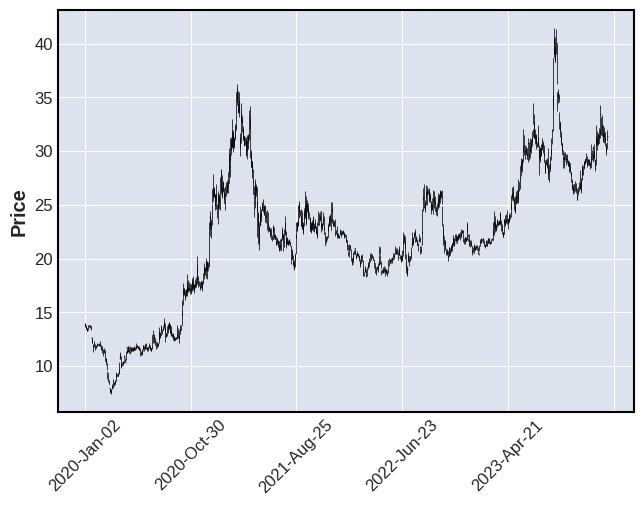

In [ ]:
mpf.plot(data)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


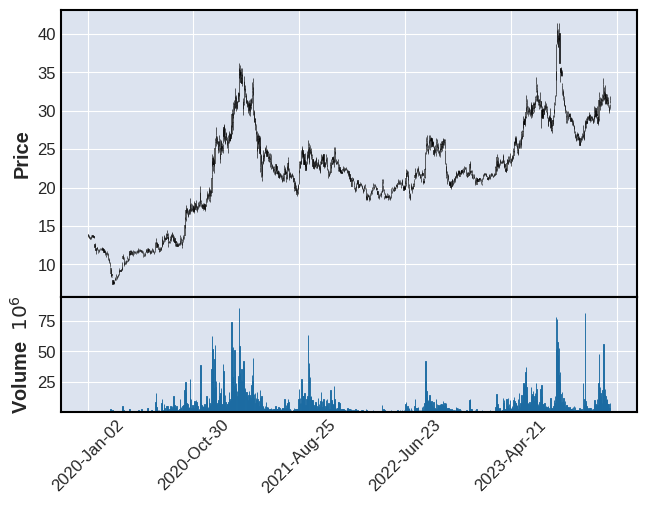

In [ ]:
mpf.plot(data,type='candle',volume=True)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


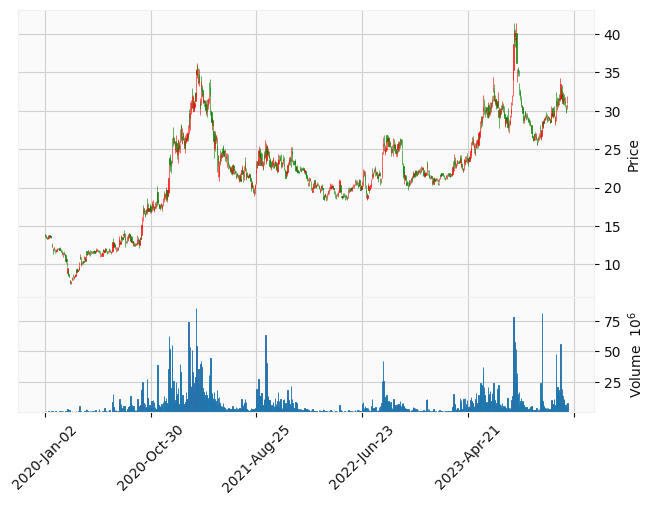

In [ ]:
ChartCandle(data)

In [ ]:
position = 0
for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_low = data.loc[c_time,'Low']
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_open = data.loc[c_time,'Open']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_open and (c_close - c_open)* 2 < (c_open - c_low):
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if i > order_i + 3 and c_close > c_open:
      position = 0
      cover_time = n_time
      cover_price = n_open
      print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)


####記錄回測明細

In [ ]:
import pandas as pd

prod = '0050'
data = getDataFM(prod,'2018-01-01','2022-05-01')

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_low = data.loc[c_time,'Low']
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_open = data.loc[c_time,'Open']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_open and (c_close - c_open)* 2 < (c_open - c_low):
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if i > order_i + 3 and c_close > c_open:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

# print(trade)

In [45]:
print(trade)

       0    1          2       3          4       5  6
0   0050  Buy 2018-01-10   84.10 2018-01-16   84.65  1
1   0050  Buy 2018-01-29   85.50 2018-02-02   84.85  1
2   0050  Buy 2018-02-05   83.20 2018-02-12   79.55  1
3   0050  Buy 2018-02-22   81.50 2018-03-02   80.85  1
4   0050  Buy 2018-03-22   84.00 2018-03-28   82.90  1
5   0050  Buy 2018-04-10   82.10 2018-04-20   81.00  1
6   0050  Buy 2018-04-26   79.70 2018-05-07   79.50  1
7   0050  Buy 2018-06-26   80.70 2018-07-02   81.50  1
8   0050  Buy 2018-08-10   85.70 2018-08-17   83.95  1
9   0050  Buy 2018-08-21   83.90 2018-08-28   85.95  1
10  0050  Buy 2018-10-09   83.05 2018-10-17   80.45  1
11  0050  Buy 2018-11-06   78.45 2018-11-13   76.15  1
12  0050  Buy 2018-11-15   77.50 2018-11-22   76.10  1
13  0050  Buy 2018-11-28   76.15 2018-12-04   78.50  1
14  0050  Buy 2018-12-14   75.80 2018-12-20   75.00  1
15  0050  Buy 2019-01-25   74.60 2019-02-13   75.95  1
16  0050  Buy 2019-02-27   77.70 2019-03-07   76.90  1
17  0050  

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


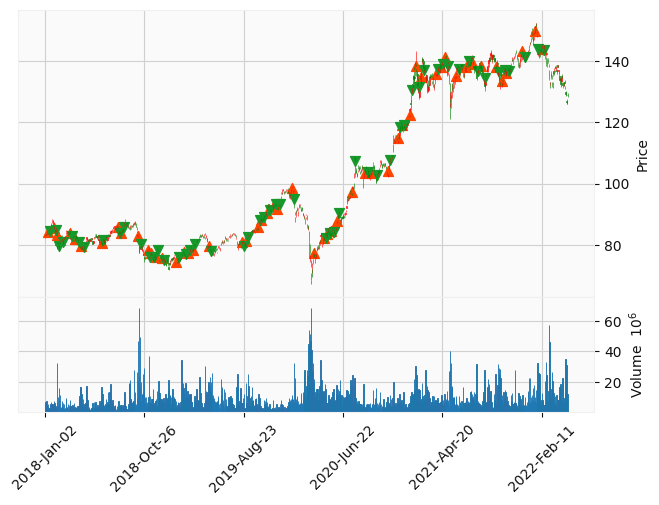

In [41]:
ChartTrade(data,trade)

總績效-0.0646
交易次數55
平均績效-0.0012
平均持有天數8天
勝率0.47
平均獲利0.0194
平均虧損-0.0196
賺賠比0.9898
期望值-0.0594
獲利平均持有天數8 days 00:00:00天
最大資金回落 0.1837


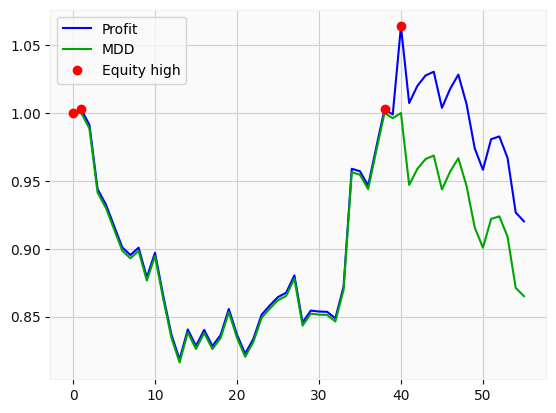

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


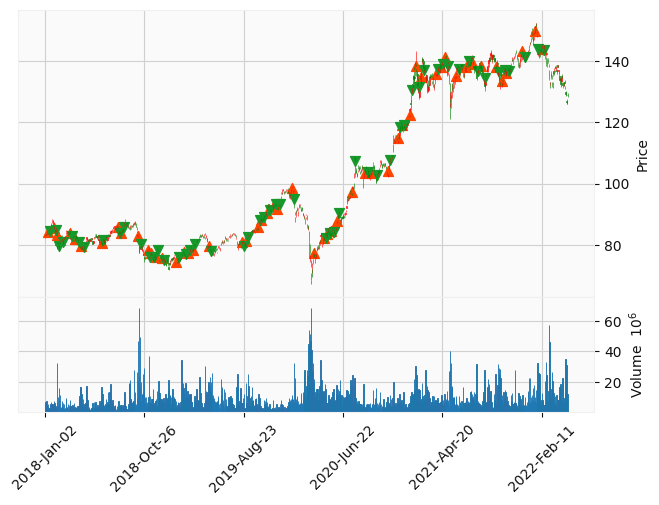

In [55]:
Performance(trade,'ETF')
ChartTrade(data,trade)